In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-22 16:28:45.062714
thunder  Sun Dec 22 16:28:45 2019
[0] GeForce GTX 1080 Ti | 45'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % | 10895 / 11178 MB | michiel(10885M)
[6] GeForce GTX 1080 Ti | 33'C,   0 % | 10895 / 11178 MB | michiel(10885M)
[7] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Dec 22 16:28:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 35%   45C    P0    74W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   26C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K


In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

Normalizing using ImageDataGenerator https://stackoverflow.com/questions/41855512/how-does-data-normalization-work-in-keras-during-prediction

### Converting the dataframe classes to integers

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True,
                                 featurewise_center=True, featurewise_std_normalization=True,
                                 rescale=1./127.5-1)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
# start = time.time()
# up_history = model.fit_generator(up_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [21]:
# print("Time taken:",end-start)

In [22]:
# plt.figure(figsize=(10,10))
# plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [24]:
# print("Time taken:",end-start)

In [25]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = {0:0.5,1:3},
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 21s 418ms/step - loss: 0.5049 - Accuracy: 0.5081 - Precision: 0.0452 - Recall: 0.4231 - F1: 0.0756 - AUC: 0.5796 - val_loss: 4.4250 - val_Accuracy: 0.0156 - val_Precision: 0.0126 - val_Recall: 0.4000 - val_F1: 0.0244 - val_AUC: 0.5079
Epoch 2/200
50/50 [==============================] - 18s 369ms/step - loss: 0.3343 - Accuracy: 0.8975 - Precision: 0.1250 - Recall: 0.1300 - F1: 0.1181 - AUC: 0.6275 - val_loss: 0.4311 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4128
Epoch 3/200
50/50 [==============================] - 21s 415ms/step - loss: 0.3649 - Accuracy: 0.8694 - Precision: 0.1157 - Recall: 0.1493 - F1: 0.1133 - AUC: 0.6477 - val_loss: 1.4895 - val_Accuracy: 0.0437 - val_Precision: 0.0284 - val_Recall: 0.7000 - val_F1: 0.0544 - val_AUC: 0.3980
Epoch 4/200
50/50 [==============================] - 21s 426ms/step - loss: 0.3240 - Accuracy: 0.8719 - Precision: 0.1252 - Recall: 0.26

Epoch 57/200
50/50 [==============================] - 19s 386ms/step - loss: 0.2623 - Accuracy: 0.9169 - Precision: 0.1913 - Recall: 0.2460 - F1: 0.1891 - AUC: 0.7729 - val_loss: 0.8549 - val_Accuracy: 0.2062 - val_Precision: 0.0451 - val_Recall: 0.5500 - val_F1: 0.0828 - val_AUC: 0.6019
Epoch 58/200
50/50 [==============================] - 19s 378ms/step - loss: 0.2956 - Accuracy: 0.9025 - Precision: 0.1947 - Recall: 0.2950 - F1: 0.2145 - AUC: 0.7563 - val_loss: 0.9512 - val_Accuracy: 0.1406 - val_Precision: 0.0240 - val_Recall: 0.5667 - val_F1: 0.0456 - val_AUC: 0.6018
Epoch 59/200
50/50 [==============================] - 19s 379ms/step - loss: 0.2489 - Accuracy: 0.9187 - Precision: 0.1683 - Recall: 0.2000 - F1: 0.1628 - AUC: 0.8087 - val_loss: 0.8800 - val_Accuracy: 0.1844 - val_Precision: 0.0353 - val_Recall: 0.6000 - val_F1: 0.0665 - val_AUC: 0.5357
Epoch 60/200
50/50 [==============================] - 19s 371ms/step - loss: 0.2833 - Accuracy: 0.9119 - Precision: 0.1483 - Recall: 

50/50 [==============================] - 20s 395ms/step - loss: 0.2616 - Accuracy: 0.9256 - Precision: 0.2120 - Recall: 0.2533 - F1: 0.2113 - AUC: 0.8216 - val_loss: 1.0682 - val_Accuracy: 0.1094 - val_Precision: 0.0274 - val_Recall: 0.3750 - val_F1: 0.0504 - val_AUC: 0.4540
Epoch 114/200
50/50 [==============================] - 21s 423ms/step - loss: 0.2154 - Accuracy: 0.9375 - Precision: 0.2247 - Recall: 0.2830 - F1: 0.2333 - AUC: 0.8364 - val_loss: 1.0505 - val_Accuracy: 0.0781 - val_Precision: 0.0196 - val_Recall: 0.5000 - val_F1: 0.0376 - val_AUC: 0.6452
Epoch 115/200
50/50 [==============================] - 20s 393ms/step - loss: 0.2270 - Accuracy: 0.9381 - Precision: 0.2183 - Recall: 0.3000 - F1: 0.2365 - AUC: 0.8156 - val_loss: 1.1422 - val_Accuracy: 0.1094 - val_Precision: 0.0245 - val_Recall: 0.4500 - val_F1: 0.0463 - val_AUC: 0.5048
Epoch 116/200
50/50 [==============================] - 20s 391ms/step - loss: 0.2593 - Accuracy: 0.9262 - Precision: 0.3150 - Recall: 0.4083 - F

50/50 [==============================] - 19s 390ms/step - loss: 0.2442 - Accuracy: 0.9287 - Precision: 0.1053 - Recall: 0.1400 - F1: 0.1131 - AUC: 0.7670 - val_loss: 0.9624 - val_Accuracy: 0.1125 - val_Precision: 0.0246 - val_Recall: 0.4000 - val_F1: 0.0458 - val_AUC: 0.4003
Epoch 170/200
50/50 [==============================] - 21s 412ms/step - loss: 0.2799 - Accuracy: 0.9331 - Precision: 0.3167 - Recall: 0.3067 - F1: 0.2864 - AUC: 0.8059 - val_loss: 1.0201 - val_Accuracy: 0.1063 - val_Precision: 0.0244 - val_Recall: 0.5500 - val_F1: 0.0465 - val_AUC: 0.4736
Epoch 171/200
50/50 [==============================] - 21s 424ms/step - loss: 0.2785 - Accuracy: 0.9200 - Precision: 0.1930 - Recall: 0.1890 - F1: 0.1739 - AUC: 0.7975 - val_loss: 1.0726 - val_Accuracy: 0.0875 - val_Precision: 0.0263 - val_Recall: 0.7000 - val_F1: 0.0505 - val_AUC: 0.5954
Epoch 172/200
50/50 [==============================] - 20s 397ms/step - loss: 0.2525 - Accuracy: 0.9275 - Precision: 0.1650 - Recall: 0.1717 - F

In [27]:
print("Time taken:",end-start)

Time taken: 3946.9019169807434


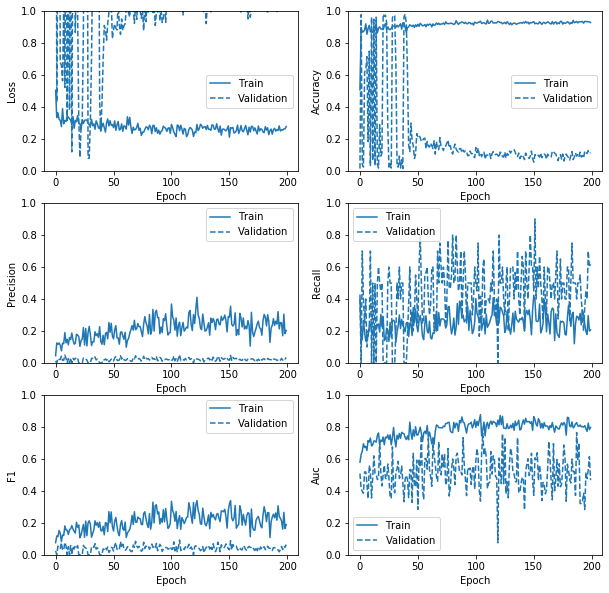

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [29]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
start = time.time()
imb_history = model.fit_generator(imb_train_generator,
                                  epochs=n_epochs,
                                  steps_per_epoch=n_steps_per_epoch,
                                  validation_data=validation_generator,
                                  validation_steps=n_validation_steps,
                                  class_weight = {0:0.5,1:6},
                                  callbacks=[reduce_lr]
                                 )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 413ms/step - loss: 0.2261 - Accuracy: 0.9463 - Precision: 0.1433 - Recall: 0.1900 - F1: 0.1533 - AUC: 0.8095 - val_loss: 1.0780 - val_Accuracy: 0.1031 - val_Precision: 0.0267 - val_Recall: 0.6000 - val_F1: 0.0509 - val_AUC: 0.7674
Epoch 2/200
50/50 [==============================] - 21s 412ms/step - loss: 0.3009 - Accuracy: 0.9388 - Precision: 0.0657 - Recall: 0.0733 - F1: 0.0550 - AUC: 0.7257 - val_loss: 1.1155 - val_Accuracy: 0.1156 - val_Precision: 0.0518 - val_Recall: 0.6500 - val_F1: 0.0928 - val_AUC: 0.6292
Epoch 3/200
50/50 [==============================] - 21s 412ms/step - loss: 0.3045 - Accuracy: 0.9469 - Precision: 0.1067 - Recall: 0.0967 - F1: 0.0900 - AUC: 0.6894 - val_loss: 1.1784 - val_Accuracy: 0.0750 - val_Precision: 0.0140 - val_Recall: 0.3000 - val_F1: 0.0265 - val_AUC: 0.6515
Epoch 4/200
50/50 [==============================] - 19s 383ms/step - loss: 0.2710 - Accuracy: 0.9406 - Precision: 0.0917 - Recall: 0.11

50/50 [==============================] - 20s 396ms/step - loss: 0.2765 - Accuracy: 0.9419 - Precision: 0.1900 - Recall: 0.2067 - F1: 0.1753 - AUC: 0.8233 - val_loss: 1.1704 - val_Accuracy: 0.1125 - val_Precision: 0.0238 - val_Recall: 0.5000 - val_F1: 0.0452 - val_AUC: 0.5874
Epoch 58/200
50/50 [==============================] - 21s 411ms/step - loss: 0.2534 - Accuracy: 0.9450 - Precision: 0.0767 - Recall: 0.1033 - F1: 0.0860 - AUC: 0.8161 - val_loss: 1.1016 - val_Accuracy: 0.1000 - val_Precision: 0.0297 - val_Recall: 0.7000 - val_F1: 0.0568 - val_AUC: 0.7540
Epoch 59/200
50/50 [==============================] - 19s 387ms/step - loss: 0.3007 - Accuracy: 0.9431 - Precision: 0.2200 - Recall: 0.2650 - F1: 0.2220 - AUC: 0.8216 - val_loss: 1.0893 - val_Accuracy: 0.0875 - val_Precision: 0.0141 - val_Recall: 0.4000 - val_F1: 0.0272 - val_AUC: 0.5390
Epoch 60/200
50/50 [==============================] - 20s 394ms/step - loss: 0.2521 - Accuracy: 0.9463 - Precision: 0.1233 - Recall: 0.1333 - F1: 

50/50 [==============================] - 20s 403ms/step - loss: 0.2723 - Accuracy: 0.9438 - Precision: 0.1100 - Recall: 0.1200 - F1: 0.1047 - AUC: 0.7357 - val_loss: 1.0745 - val_Accuracy: 0.1031 - val_Precision: 0.0105 - val_Recall: 0.2000 - val_F1: 0.0198 - val_AUC: 0.6381
Epoch 114/200
50/50 [==============================] - 20s 393ms/step - loss: 0.2493 - Accuracy: 0.9438 - Precision: 0.0440 - Recall: 0.0800 - F1: 0.0533 - AUC: 0.7140 - val_loss: 1.1385 - val_Accuracy: 0.0906 - val_Precision: 0.0234 - val_Recall: 0.7000 - val_F1: 0.0452 - val_AUC: 0.5246
Epoch 115/200
50/50 [==============================] - 20s 399ms/step - loss: 0.2573 - Accuracy: 0.9500 - Precision: 0.0600 - Recall: 0.0900 - F1: 0.0700 - AUC: 0.7491 - val_loss: 1.0589 - val_Accuracy: 0.1219 - val_Precision: 0.0304 - val_Recall: 0.5500 - val_F1: 0.0572 - val_AUC: 0.5677
Epoch 116/200
50/50 [==============================] - 20s 401ms/step - loss: 0.2785 - Accuracy: 0.9425 - Precision: 0.0867 - Recall: 0.1367 - F

50/50 [==============================] - 21s 416ms/step - loss: 0.2657 - Accuracy: 0.9438 - Precision: 0.1517 - Recall: 0.1850 - F1: 0.1453 - AUC: 0.8052 - val_loss: 1.0530 - val_Accuracy: 0.0938 - val_Precision: 0.0298 - val_Recall: 0.5000 - val_F1: 0.0557 - val_AUC: 0.7285
Epoch 170/200
50/50 [==============================] - 20s 396ms/step - loss: 0.2966 - Accuracy: 0.9388 - Precision: 0.0817 - Recall: 0.1200 - F1: 0.0874 - AUC: 0.7852 - val_loss: 1.0670 - val_Accuracy: 0.0875 - val_Precision: 0.0333 - val_Recall: 0.5667 - val_F1: 0.0624 - val_AUC: 0.4788
Epoch 171/200
50/50 [==============================] - 20s 409ms/step - loss: 0.2615 - Accuracy: 0.9525 - Precision: 0.1467 - Recall: 0.1367 - F1: 0.1293 - AUC: 0.7935 - val_loss: 1.1241 - val_Accuracy: 0.0625 - val_Precision: 0.0259 - val_Recall: 0.7000 - val_F1: 0.0498 - val_AUC: 0.5130
Epoch 172/200
50/50 [==============================] - 21s 417ms/step - loss: 0.3154 - Accuracy: 0.9475 - Precision: 0.1067 - Recall: 0.1100 - F

In [33]:
print("Time taken:",end-start)

Time taken: 4007.514619588852


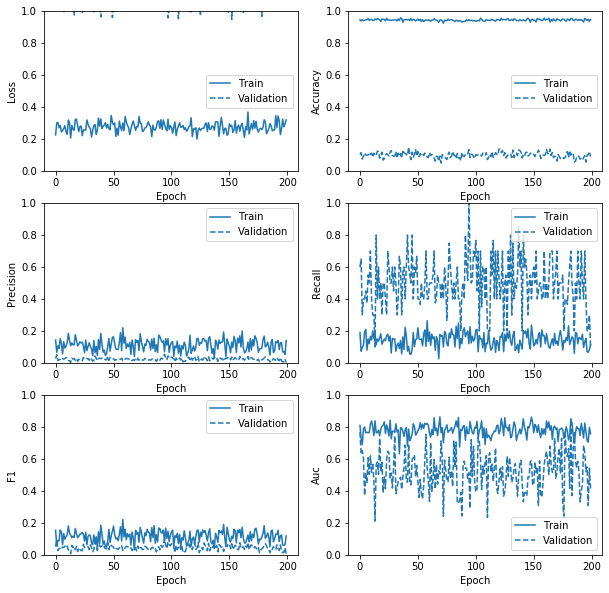

In [34]:
plt.figure(figsize=(10,10))
plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 21s 207ms/step


In [36]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.909 :   1.106
Accuracy : 0.289 :   0.097
Precision : 0.028 :   0.022
Recall : 0.445 :   0.472
F1 : 0.052 :   0.041
AUC : 0.526 :   0.533


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1289.0890130996704, 201.23238396644592)

In [38]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [39]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [40]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

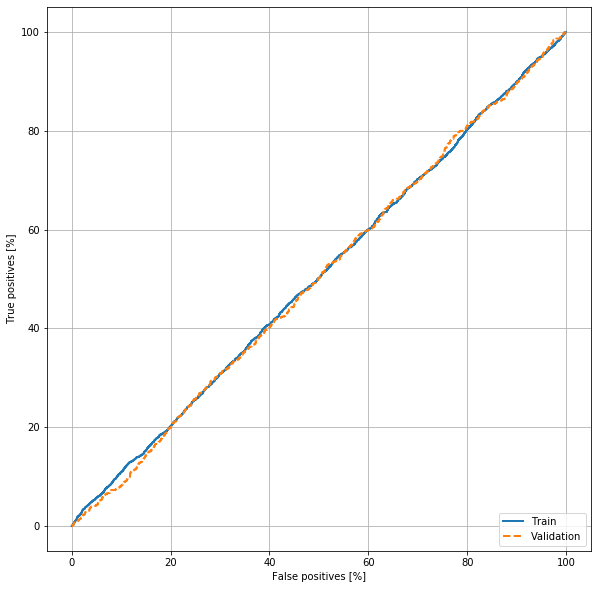

In [41]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 27502 
FP: 71953 
FN: 666 
TP: 1713


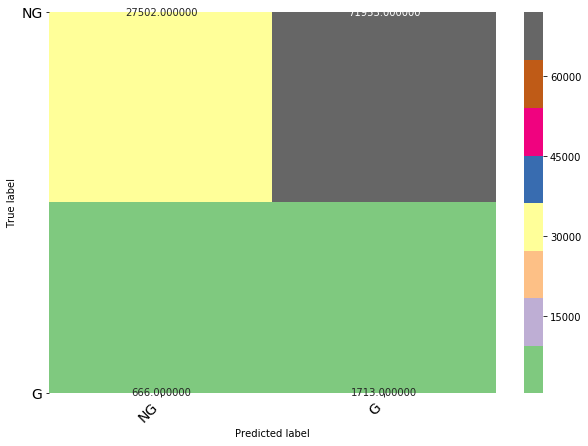

In [71]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
cm = confusion_matrix(train_labels, pred_tr > 0.5)
print_confusion_matrix(cm, ['NG','G'])

Validation data: 
TN: 2613 
FP: 30521 
FN: 66 
TP: 743


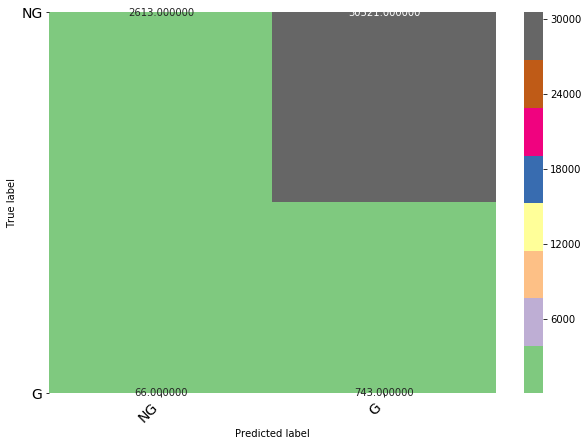

In [74]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
cm = confusion_matrix(val_labels, pred_vl > 0.5)
print_confusion_matrix(cm, ['NG','G'])

### MLFlow 

In [76]:
# get_notebook_name()

<IPython.core.display.Javascript object>

'CNN Fundus- train_twice-Copy7.ipynb'

In [45]:
# history = up3_history
# tag_value = "same as copy 6 with 1:20 and 1:40"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [46]:
# client = MlflowClient()
# run = client.create_run('21')
# client.set_tag(run.info.run_id, "tag_key", tag_value)